<a href="https://colab.research.google.com/github/Stephanie9606/Multimodal_Deep_Learning/blob/main/multiclass_mulitimodal_early_fusion_memes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LSTM

In [3]:
import tensorflow_hub as hub
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import re
import glob
import os
import cv2
import sys
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from tensorflow.keras.utils import plot_model

In [4]:
# Set up the device for GPU usage
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# connect to google drive for files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-processing

In [ ]:
# unzip image file
!unzip /content/drive/MyDrive/memes_image.zip

In [7]:
memesDF = pd.read_csv('/content/drive/MyDrive/top5_memes_tidy.tsv', sep='\t')

In [8]:
memesDF = memesDF.iloc[:, 2:9]

In [9]:
memesDF['AltText'] = memesDF['AltText'].astype(pd.StringDtype())
memesDF['MemeLabel'] = memesDF['MemeLabel'].astype(pd.StringDtype())
memesDF['CaptionText'] = memesDF['CaptionText'].astype(pd.StringDtype())
memesDF['HashId'] = memesDF['HashId'].astype(pd.StringDtype())
memesDF['ImageURL'] = memesDF['ImageURL'].astype(pd.StringDtype())
memesDF['ImagePath'] = memesDF['ImagePath'].astype(pd.StringDtype())
memesDF['Image'] = memesDF['Image'].astype(pd.StringDtype())

In [10]:
memes5cDF = memesDF
memes5cDF.head(3)

,AltText,CaptionText,ImageURL,HashId,MemeLabel,ImagePath,Image
0,Coke in Regal Cinemas > Pepsi in Regal Cinemas...,WHO WANTS A PEPSI?,http://i.imgflip.com/3xa87f.jpg,b54073fe552aa582c57a1a39e9db3f550067775516b844...,Who Killed Hannibal,/content/memes_image/3xa87f.jpg,3xa87f.jpg
1,Who Killed Hannibal | NORTH KOREA PEOPLE WITH ...,NORTH KOREA PEOPLE WITH CORONAVIRUS WE HAVE 0...,http://i.imgflip.com/3v9nm3.jpg,55a37d7aac7c769f4d517ea20b50c8ffa8e545491e45c1...,Who Killed Hannibal,/content/memes_image/3v9nm3.jpg,3v9nm3.jpg
2,Who Killed Hannibal | MINECRAFT CAVE UPDATE MI...,MINECRAFT CAVE UPDATE MINECRAFT,http://i.imgflip.com/3xjml3.jpg,ba01cf5a250ad0d9dc2901c5250ddf0e49abc8fb8e0a80...,Who Killed Hannibal,/content/memes_image/3xjml3.jpg,3xjml3.jpg


In [11]:
# train test split
from sklearn.model_selection import train_test_split

me_trainDF, me_testDF = train_test_split(memes5cDF, test_size=0.25, random_state=15)

In [12]:
me_trainDF, me_valDF = train_test_split(me_trainDF, test_size=0.25, random_state=13)

In [13]:
n1 = me_trainDF.index
n2 = me_valDF.index
n3 = me_testDF.index
print(n1)
print(n2)
print(n3)

Int64Index([1602, 3314, 4470, 3996, 3421, 1298, 4837, 1192, 3800,  283,
            ...
            4484, 1934, 5681, 1527, 2643, 3247, 1040, 4497, 1886,  242],
           dtype='int64', length=3343)
Int64Index([3894, 1864,  466, 4656, 5752, 3396,  456, 4954, 3594,  860,
            ...
            1464,  143, 3698, 2877, 3265, 2202, 2277,  157, 1311, 1087],
           dtype='int64', length=1115)
Int64Index([ 518, 5716, 2585, 5197, 1916,  748, 3401, 4641, 4246, 4502,
            ...
            1169, 4416, 5032,  163, 1918, 1590, 1335, 4330, 3234, 3673],
           dtype='int64', length=1486)


In [14]:
me_trainDF = me_trainDF.iloc[0:3328,:]
me_valDF = me_valDF.iloc[0:1088,:]
me_testDF = me_testDF.iloc[0:1472,:]

# Image Pre-processing

In [15]:
 # Loading training data
img_height = 224
img_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)
val_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)
train_generator = train_datagen.flow_from_dataframe(dataframe=me_trainDF, 
                                                    directory=None, 
                                                    x_col="ImagePath", 
                                                    y_col="MemeLabel", 
                                                    class_mode="categorical", 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size,
                                                    shuffle=False)

valid_generator = val_datagen.flow_from_dataframe(dataframe=me_valDF, 
                                                    directory=None, 
                                                    x_col="ImagePath", 
                                                    y_col="MemeLabel", 
                                                    class_mode="categorical", 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size,
                                                    shuffle=False)

print(f"Class labels: {train_generator.class_indices}")
print(f"Class labels: {valid_generator.class_indices}")

#step_size = train_generator.n//train_generator.batch_size

Found 3328 validated image filenames belonging to 5 classes.
Found 1088 validated image filenames belonging to 5 classes.
Class labels: {'Peter Parker Cry': 0, 'Scared Cat': 1, 'Sleeping Shaq': 2, 'Uncle Sam': 3, 'Who Killed Hannibal': 4}
Class labels: {'Peter Parker Cry': 0, 'Scared Cat': 1, 'Sleeping Shaq': 2, 'Uncle Sam': 3, 'Who Killed Hannibal': 4}


In [16]:
images, labels = next(train_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32, 5)


In [17]:
# convert generator to tf.dataset: image_train_data, image_val_data
image_train_data = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,224,224,3], [32,5]) # based on batch_size change
)

image_val_data = tf.data.Dataset.from_generator(
    lambda: valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,224,224,3], [32,5])
)

In [18]:
# check data's structure
image_train_data.element_spec
image_val_data.element_spec

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [19]:
# image train, val batch drop remainder
#image_train_data = image_train_data.unbatch()
#image_train_data = image_train_data.batch(32, drop_remainder=True)

#image_val_data = image_val_data.unbatch()
#image_val_data = image_val_data.batch(32, drop_remainder=True)

#image_train_data.element_spec
#image_val_data.element_spec

In [20]:
# Loading testing data
test_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)
batch_size = 32

test_generator = test_datagen.flow_from_dataframe(dataframe=me_testDF, 
                                                  directory=None, 
                                                  x_col="ImagePath", 
                                                  y_col="MemeLabel", 
                                                  class_mode="categorical", 
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False)

print(f"Class labels: {test_generator.class_indices}")

Found 1472 validated image filenames belonging to 5 classes.
Class labels: {'Peter Parker Cry': 0, 'Scared Cat': 1, 'Sleeping Shaq': 2, 'Uncle Sam': 3, 'Who Killed Hannibal': 4}


In [21]:
images, labels = next(test_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32, 5)


In [22]:
# convert generator to tf.dataset: image_test_data
image_test_data = tf.data.Dataset.from_generator(
    lambda: valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,224,224,3], [32,5])
)

In [23]:
image_test_data.element_spec

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [24]:
# image test batch drop remainder
image_test_data = image_test_data.unbatch()
image_test_data = image_test_data.batch(32, drop_remainder=True)

image_test_data.element_spec

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

# Text Pre-processing for BERT

BERT: [CLS] + text + [SEP]

In [25]:
!pip install -q transformers

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

     |████████████████████████████████| 4.0 MB 22.0 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.6 MB/s 
     |████████████████████████████████| 596 kB 60.0 MB/s 
     |████████████████████████████████| 895 kB 67.1 MB/s 


In [26]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 173 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=8b683f32256fb55001ba903f36cc8e749c76db88b9adfdbd6a3ff243b2ed2e8e
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=fda69a429ce13e2138e27789ac8e57f82d18758478c5e1bc64451c753a7889cd
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=65b9a5c7da278cc2278da86fec05a3bc794c2f6e862ade4a29b0913f12083d82
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [27]:
#!pip3 install tensorflow_hub

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Model 
import bert

In [28]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
# convert_data_to_examples: accept train and test datasets and convert each row into an InputExample object.
def convert_data_to_examples(train, val, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None, 
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None, 
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  test_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None, 
                                                          label = x[LABEL_COLUMN]), axis = 1)  
  
  return train_InputExamples, validation_InputExamples, test_InputExamples

  train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(me_trainDF,
                                                                                               me_valDF, 
                                                                                               me_testDF, 
                                                                                              'CaptionText', 
                                                                                              'MemeLabel')

In [30]:
# convert_examples_to_tf_dataset: tokenize the InputExample objects, then create the required input format with the tokenized objects 
# finally, create an input dataset that we can feed to the model.
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length", # pad_to_max_length=True
            truncation=True
        )
        
        #print(len(input_dict))

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
    def gen():
        for f in features:
            yield (
                  f.input_ids,
                  f.attention_mask,
                  f.token_type_ids
                ,
                # f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        (tf.int32, tf.int32, tf.int32),
        (
              tf.TensorShape([128]),
              tf.TensorShape([128]),
              tf.TensorShape([128])
            ,
            # tf.TensorShape([]),
        ),
    )

DATA_COLUMN = 'CaptionText'
LABEL_COLUMN = 'MemeLabel'

In [31]:
# call above function
train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(me_trainDF, me_valDF, me_testDF, DATA_COLUMN, LABEL_COLUMN)

text_train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
text_train_data = text_train_data.batch(32, drop_remainder=True)

text_val_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
text_val_data = text_val_data.batch(32, drop_remainder=True)

text_test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
text_test_data = text_test_data.batch(32, drop_remainder=True)

In [32]:
text_train_data.element_spec

(TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None))

In [33]:
elem = next(iter(text_train_data))
elem

(<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[  101,  2304,  3268, ...,     0,     0,     0],
        [  101, 18168,  2290, ...,     0,     0,     0],
        [  101,  1045,  2215, ...,     0,     0,     0],
        ...,
        [  101,  2017,  2215, ...,     0,     0,     0],
        [  101,  2043,  2017, ...,     0,     0,     0],
        [  101,  4931,  2848, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)

# Merge image and text tf.dataset

In [34]:
text_train_data.element_spec

(TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
 TensorSpec(shape=(32, 128), dtype=tf.int32, name=None))

In [35]:
# merged train data
try_data = tf.data.Dataset.zip((image_train_data, text_train_data))
try_data.element_spec
train_data = try_data.map(lambda x, y: ((x[0], y[0], y[1], y[2]), x[1]))
train_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [36]:
# merged validation data
try_data1 = tf.data.Dataset.zip((image_val_data, text_val_data))
try_data1.element_spec
val_data = try_data1.map(lambda x, y: ((x[0], y[0], y[1], y[2]), x[1]))
val_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [37]:
# merged validation data
try_data2 = tf.data.Dataset.zip((image_test_data, text_test_data))
try_data2.element_spec
test_data = try_data2.map(lambda x, y: ((x[0], y[0], y[1], y[2]), x[1]))
test_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

# Early Fusion: load pre-trained model + build multi-model

***--- Image Model ---***

In [38]:
# Load original model with pretrained weights from imagenet
base_model = applications.VGG16(weights="imagenet")

# Freeze base model
base_model.trainable = False

# Create new model (deeper) on top
img_height = 224
img_width = 224
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
outputs = Dense(128)(x)  # no activation function here for early fusion

vgg16_model = Model(inputs, outputs)
vgg16_model.summary()

553476096/553467096 [==============================] - 14s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
Total params: 138,485,672
Trainable params: 128,128
Non-trainable params: 138,357,544
_________________________________________________________________


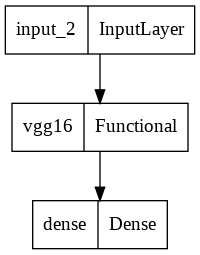

In [39]:
plot_model(vgg16_model)

***--- Text Model ---***

In [40]:
#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
#                            trainable=True)

In [41]:
max_length = 128
input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
lstm_out = layers.Bidirectional(LSTM(128, name='LSTM'))(sequence_output) # Bidirectional LSTM instead of LSTM

#bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=lstm_out)

In [42]:
#pooled_output.shape

In [43]:
# Keep the Bert layers trainable
for layer in bert_model.layers:
    layer.trainable = True

In [44]:
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

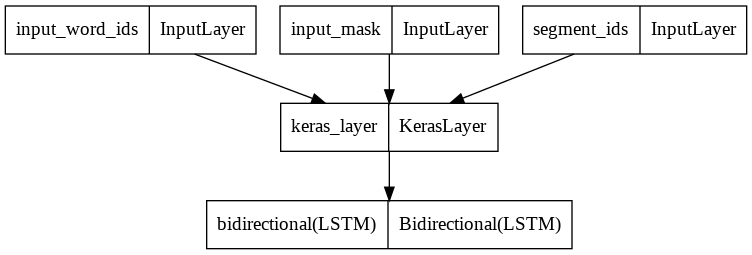

In [45]:
plot_model(bert_model)

***--- Multimodal ---***

In [46]:
# Stacking early-fusion multimodal model
#nClasses = 2 # for multi-class

input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="segment_ids")
image_input = layers.Input(shape=(img_height, img_width, 3), dtype=tf.float32,
                                       name="image")

image_side = vgg16_model(image_input)
text_side = bert_model([input_word_ids, input_mask, segment_ids])
# Concatenate features from images and texts
merged = layers.Concatenate()([image_side, text_side])
merged = layers.Dense(256, activation = 'relu')(merged)
output = layers.Dense(5, activation='softmax', name = "class")(merged) # 5 classes

merge_model = models.Model([image_input, input_word_ids, input_mask, segment_ids], output)

In [47]:
merge_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                         

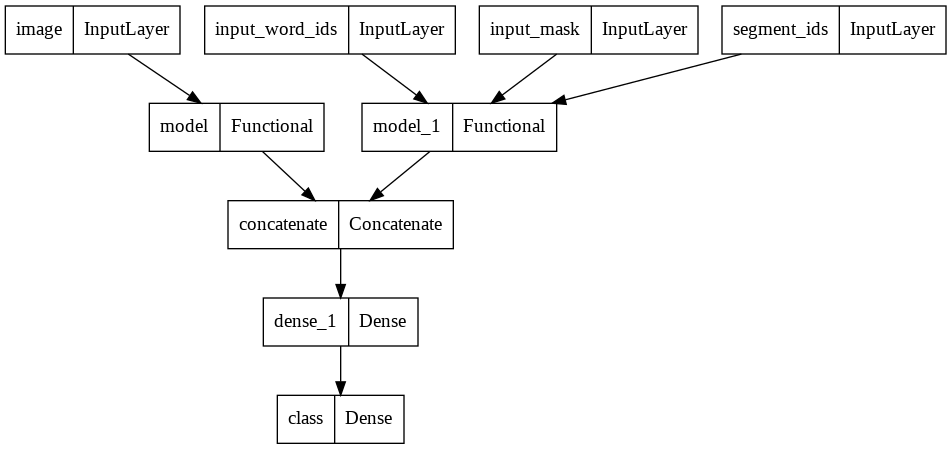

In [48]:
plot_model(merge_model)

# Model Compile

In [49]:
#!pip install mlflow

In [50]:
#import mlflow.tensorflow
from tensorflow.keras.optimizers import Adam

In [51]:
# Check out the MLflow UI as this runs
#mlflow.tensorflow.autolog(every_n_iter=2)

In [52]:
# optimizer and metric
merge_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"]) # default lr = 0.001

In [53]:
train_data.element_spec

((TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [54]:
#step_size_train = 1308//32
#step_size_valid = 437//32

In [55]:
#step_size_train=train_data.n//train_data.batch_size
#step_size_valid=valid_generator.n//valid_generator.batch_size

In [56]:
# Train the model 
earlyfs_history = merge_model.fit(train_data,
                #steps_per_epoch=step_size_train, #tf.dataset is none
                validation_data=val_data,
                #validation_steps=step_size_valid,
                epochs=10,
                verbose=2 # show: epoch 1/10...
)

Epoch 1/10
104/104 - 149s - loss: 1.4450 - accuracy: 0.3846 - val_loss: 0.9407 - val_accuracy: 0.6838 - 149s/epoch - 1s/step
Epoch 2/10
104/104 - 114s - loss: 0.5249 - accuracy: 0.9258 - val_loss: 0.2048 - val_accuracy: 0.9908 - 114s/epoch - 1s/step
Epoch 3/10
104/104 - 120s - loss: 0.1108 - accuracy: 0.9907 - val_loss: 0.0519 - val_accuracy: 0.9963 - 120s/epoch - 1s/step
Epoch 4/10
104/104 - 120s - loss: 0.0418 - accuracy: 0.9946 - val_loss: 0.0299 - val_accuracy: 0.9972 - 120s/epoch - 1s/step
Epoch 5/10
104/104 - 120s - loss: 0.0262 - accuracy: 0.9949 - val_loss: 0.0201 - val_accuracy: 0.9991 - 120s/epoch - 1s/step
Epoch 6/10
104/104 - 116s - loss: 0.0194 - accuracy: 0.9967 - val_loss: 0.0141 - val_accuracy: 0.9982 - 116s/epoch - 1s/step
Epoch 7/10
104/104 - 121s - loss: 0.0155 - accuracy: 0.9976 - val_loss: 0.0106 - val_accuracy: 0.9982 - 121s/epoch - 1s/step
Epoch 8/10
104/104 - 121s - loss: 0.0130 - accuracy: 0.9973 - val_loss: 0.0085 - val_accuracy: 0.9982 - 121s/epoch - 1s/step


In [57]:
# Evaluate
#step_size_test = test_generator.n//test_generator.batch_size

In [58]:
eval_results = merge_model.evaluate(test_data)
                                    #steps=step_size_test
print(f"loss: {eval_results[0]}. accuracy: {eval_results[1]}")

46/46 [==============================] - 21s 450ms/step - loss: 0.0076 - accuracy: 0.9986
loss: 0.007555330637842417. accuracy: 0.998641312122345


# Plot

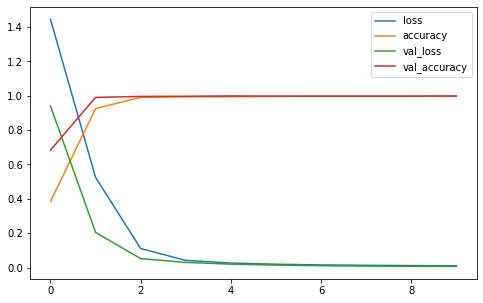

In [59]:
pd.DataFrame(earlyfs_history.history).plot(figsize=(8,5))
plt.show()

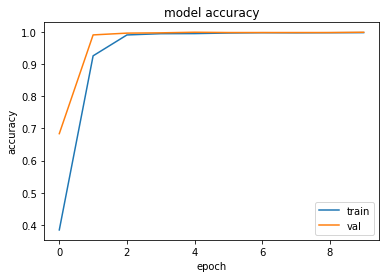

In [64]:
# plot accuracy
plt.plot(earlyfs_history.history['accuracy'])
plt.plot(earlyfs_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

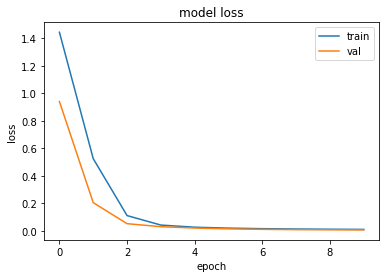

In [63]:
# plot loss
plt.plot(earlyfs_history.history['loss'])
plt.plot(earlyfs_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()